## First: Introduce DIP to generate prior model

### Import Library

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from deep_image_prior.utils import *
from deep_image_prior.unet import *

import torch
import torch.nn as nn
import torch.optim
from torchvision import transforms, datasets

from skimage.metrics import peak_signal_noise_ratio

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
# device = "cuda" if torch.cuda.is_available() else "cpu"

imsize =-1
PLOT = False
sigma = 25
sigma_ = sigma/255.

### Download CIFAR10 dataset and pick one of them to train

Files already downloaded and verified


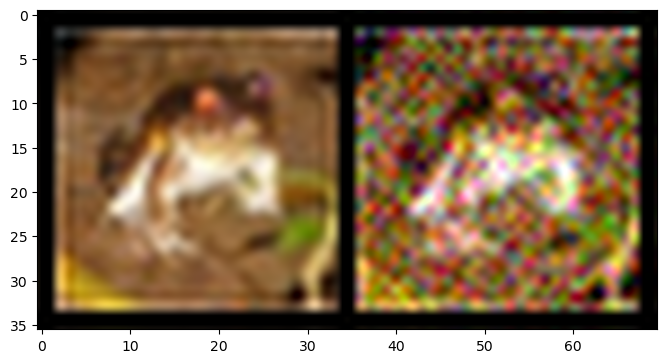

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.23137255, ..., 0.6539544 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.69411767, ..., 0.55536866,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.24313726, ..., 0.7041883 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.5647059 , ..., 0.4598898 ,
         0.        , 0.        ],
        [0. 

In [2]:
dataset = datasets.CIFAR10(root='./data', train=True, download=True)
image, _ = dataset[0]
img_np = pil_to_np(image)

# get the guassian noise or the meshgrid of the image
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
plot_image_grid([img_np, img_noisy_np], 4, 6)

### DIP training structure setup

In [3]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 1000
input_depth = 32 
figsize = 4 

module = SkipArchitecture(
                input_depth, 3, 
                num_channels_down = [128, 128, 128, 128, 128], 
                num_channels_up   = [128, 128, 128, 128, 128],
                num_channels_skip = [128, 128, 128, 128, 128], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad).type(dtype)


module_input = get_noise(input_depth, INPUT, (image.size[1], image.size[0])).type(dtype).detach()

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in module.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2864643


### Train the DIP model

In [4]:
module_input_saved = module_input.detach().clone()
noise = module_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    global i, out_avg, psrn_noisy_last, last_net, module_input
    
    if reg_noise_std > 0:
        module_input = module_input_saved + (noise.normal_() * reg_noise_std)
    
    # print(module_input)
    out = module(module_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    
    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, module.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in module.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, module, module_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


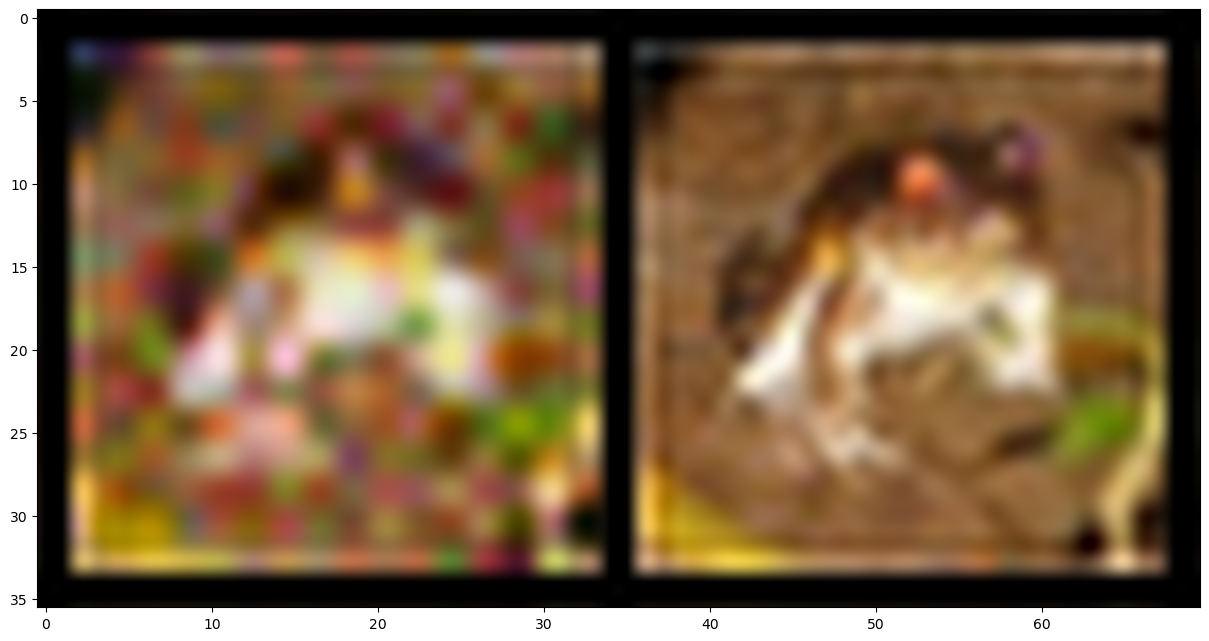

In [5]:
torch.save(module, "dip_module.mod")
out_np = torch_to_np(module(module_input))
q = plot_image_grid([out_np, img_np], factor=13)

## Second: Use DIP model to prior the DDPM model

The goal is to accelerate the progress of DDPM

In [6]:
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm
from pathlib import Path

from denoising_diffusion_probabilistic.denoising_diffusion_probabilistic import DDPM
from denoising_diffusion_probabilistic.ddpm_unet import DDPMUnet
from denoising_diffusion_probabilistic.utils import *

In [7]:
image_size = 32 # CIFAR10 dataset
image_channels = 3 # CIFAR10 dataset
train_batch_size = 128 # CIFAR10 dataset
eval_batch_size = 6
num_epochs = 100
start_epoch = 0
learning_rate = 2e-5
diffusion_timesteps = 800
save_image_epochs = 5
save_model_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42
resume = None

print(device)

cuda


In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [9]:
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_dataloader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

Files already downloaded and verified


In [10]:
# module = torch.load("dip_module.mod")
ddpm_model = DDPMUnet().to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                            T_max=len(train_dataloader) * num_epochs,
                                                            last_epoch=-1,
                                                            eta_min=1e-9)
ddpm_process = DDPM(num_timesteps=diffusion_timesteps)

In [11]:
def compute_rmse(real_images, generated_images):
    mse = torch.mean((real_images - generated_images) ** 2, dim=[1, 2, 3])
    rmse = torch.sqrt(mse)
    return rmse.cpu().numpy()

def eval_rsme_plot(real_images, generated_images):
    rmse_list = []
    for gen in generated_images:
        rsme = compute_rmse(real_images, gen)
        rmse_list.append(rsme)
    rmse_array = np.array(rmse_list)
    
    timesteps = np.arange(diffusion_timesteps)

    # Plot rate-distortion curve
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, rmse_array)
    plt.xlabel('Reverse process timesteps')
    plt.ylabel('Distortion (RMSE)')
    plt.title('Rate-Distortion Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def evaluate(epoch, dip_model, pipeline, ddpm_model):  
    # generate the RMSE plot of each timesteps (at the last epoch of each training)
    if epoch == num_epochs:
        noisy_sample = torch.randn(1, image_channels, image_size, image_size).to(device)
        
        test_image = None
        pbar = tqdm(train_dataloader)
        for origin_images, labels in pbar:
            test_image = origin_images[0]
            test_image = test_image.to(device)
            break

        generated_images = pipeline.sampling(ddpm_model, dip_model, noisy_sample, 1, device=device, save_all_steps=True)
        generated_images = np.array(generated_images)
        generated_images = torch.from_numpy(generated_images).to(device)
        eval_rsme_plot(test_image, generated_images)

    # The noise sample for the output images
    noisy_sample = torch.randn(eval_batch_size, image_channels, image_size, image_size).to(device)
                   
    # Reverse diffusion for T timesteps
    images = pipeline.sampling(ddpm_model, dip_model, noisy_sample, eval_batch_size, device=device, save_all_steps=False)

    # Postprocess and save sampled images
    images = postprocess(images)
    image_grid = create_images_grid(images, rows=2, cols=3)

    grid_save_dir = Path("output_img/")
    grid_save_dir.mkdir(parents=True, exist_ok=True)
    image_grid.save(f"{grid_save_dir}/{epoch:04d}.png")

100%|██████████| 800/800 [00:10<00:00, 76.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


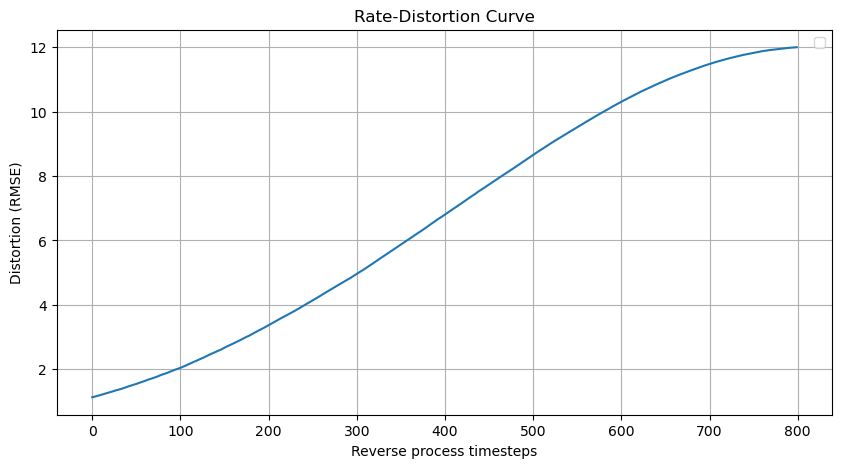

100%|██████████| 800/800 [00:10<00:00, 75.70it/s]


In [13]:
WITH_DIP_PRIOR = True
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader)
    pbar.set_description(f"Training epoch {epoch + 1}/{num_epochs}")
    
    ddpm_model.train()
    for origin_images, labels in pbar:
        batch_size = origin_images.shape[0]
        origin_images = origin_images.to(device)
        
        timesteps = torch.randint(0, diffusion_timesteps, (batch_size, ), device=device)
        
        noisey_images, noise = ddpm_process.forward_diffusion(origin_images, timesteps, module if WITH_DIP_PRIOR else None, batch_size)
        noisey_images = noisey_images.to(device)
        
        noise_pred = ddpm_model(noisey_images, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(ddpm_model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss = loss.item())
        
    if (epoch + 1) % save_image_epochs == 0 or epoch == num_epochs - 1:
        ddpm_model.eval()
        evaluate(epoch + 1, module if WITH_DIP_PRIOR else None, ddpm_process, ddpm_model)
        
        torch.save(ddpm_model, f"ddpm_model/num_{epoch}.mod")